In [3]:
using Oceananigans

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA C:\Users\shiva\.julia\packages\CUDA\DL5Zo\src\initialization.jl:42


In [9]:
grid = RectilinearGrid(size=(128,128),x=(-pi,pi),z=(-pi,pi),topology=(Periodic,Flat,Periodic))

RectilinearGrid{Float64, Periodic, Flat, Periodic}
             architecture: CPU()
                   domain: x ∈ [-3.141592653589793, 3.141592653589793], y ∈ [1.0, 1.0], z ∈ [-3.141592653589793, 3.141592653589793]
                 topology: (Periodic, Flat, Periodic)
        size (Nx, Ny, Nz): (128, 1, 128)
        halo (Hx, Hy, Hz): (1, 0, 1)
             spacing in x: Regular, with spacing 0.04908738521234052
             spacing in y: Flattened
             spacing in z: Regular, with spacing 0.04908738521234052

In [10]:
coriolis=FPlane(f=0.2)

FPlane{Float64}: f = 2.00e-01

In [12]:
B_func(x,y,z,t,N)=N^2*z
N=1
B=BackgroundField(B_func,parameters=N)

BackgroundField{typeof(B_func), Int64}
├── func: B_func
└── parameters: 1

In [19]:
model=NonhydrostaticModel(grid = grid,
            advection = CenteredFourthOrder(),
          timestepper = :RungeKutta3,
              closure = IsotropicDiffusivity(ν=1e-6, κ=1e-6),
             coriolis = coriolis,
              tracers = :b,
    background_fields = (b=B,), 
             buoyancy = BuoyancyTracer())

┌ Warning: Inflating model grid halo size to (2, 0, 2) and recreating grid. The model grid will be different from the input grid. To avoid this warning, pass halo=(2, 0, 2) when constructing the grid.
└ @ Oceananigans.Models.NonhydrostaticModels C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Models\NonhydrostaticModels\nonhydrostatic_model.jl:130


NonhydrostaticModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RectilinearGrid{Float64, Periodic, Flat, Periodic}(Nx=128, Ny=1, Nz=128)
├── tracers: (:b,)
├── closure: IsotropicDiffusivity{Oceananigans.TurbulenceClosures.ExplicitTimeDiscretization, Float64, NamedTuple{(:b,), Tuple{Float64}}}
├── buoyancy: BuoyancyTracer
└── coriolis: FPlane{Float64}

In [20]:
m = 16   
k = 8       
f = coriolis.f

ω² = (N^2 * k^2 + f^2 * m^2) / (k^2 + m^2)

ω = sqrt(ω²)


0.48166378315169184

In [21]:
A = 1e-9
δ = grid.Lx / 15

a(x, z) = A * exp( -( x^2 + z^2 ) / 2δ^2 )

a (generic function with 1 method)

In [23]:
u₀(x, y, z) = a(x, z) * k * ω   / (ω^2 - f^2) * cos(k*x + m*z)
v₀(x, y, z) = a(x, z) * k * f   / (ω^2 - f^2) * sin(k*x + m*z)
w₀(x, y, z) = a(x, z) * m * ω   / (ω^2 - N^2) * cos(k*x + m*z)
b₀(x, y, z) = a(x, z) * m * N^2 / (ω^2 - N^2) * sin(k*x + m*z)

set!(model, u=u₀, v=v₀, w=w₀, b=b₀)

In [24]:
simulation = Simulation(model, Δt = 0.1 * 2π/ω, stop_iteration = 15)

Simulation{typename(NonhydrostaticModel){typename(CPU), Float64}}
├── Model clock: time = 0 seconds, iteration = 0
├── Next time step: 1.304 seconds
├── Elapsed wall time: 0 seconds
├── Stop time: Inf years
├── Stop iteration : 15.0
├── Wall time limit: Inf
├── Callbacks: typename(OrderedCollections.OrderedDict) with 4 entries:
│   ├── stop_time_exceeded => typename(Callback)
│   ├── stop_iteration_exceeded => typename(Callback)
│   ├── wall_time_limit_exceeded => typename(Callback)
│   └── nan_checker => typename(Callback)
├── Output writers: typename(OrderedCollections.OrderedDict) with no entries
└── Diagnostics: typename(OrderedCollections.OrderedDict) with no entries

In [25]:
simulation.output_writers[:velocities] = JLD2OutputWriter(model, model.velocities,
                                                          schedule = IterationInterval(1),
                                                            prefix = "internal_wave",
                                                             force = true)

JLD2OutputWriter scheduled on IterationInterval(1):
├── filepath: .\internal_wave.jld2
├── 3 outputs: (:u, :v, :w)
├── field slicer: FieldSlicer(:, :, :, with_halos=false)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

In [26]:
run!(simulation)

┌ Info: Initializing simulation...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:168
┌ Info:     ... simulation initialization complete (8.117 seconds)
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:190
┌ Info: Executing initial time step...
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:113
┌ Info:     ... initial time step complete (1.336 minutes).
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\run.jl:120
┌ Info: Simulation is stopping. Model iteration 15 has hit or exceeded simulation stop iteration 15.
└ @ Oceananigans.Simulations C:\Users\shiva\.julia\packages\Oceananigans\KUskb\src\Simulations\simulation.jl:155


In [28]:
using JLD2, Printf, Plots

In [27]:
x, y, z = nodes(model.velocities.w)

([-3.117048960983623, -3.0679615757712826, -3.0188741905589422, -2.9697868053466014, -2.920699420134261, -2.8716120349219203, -2.82252464970958, -2.7734372644972396, -2.724349879284899, -2.6752624940725585  …  2.675262494072558, 2.7243498792848984, 2.773437264497239, 2.8225246497095795, 2.87161203492192, 2.9206994201342606, 2.969786805346601, 3.018874190558942, 3.067961575771282, 3.1170489609836225], StepRangeLen(1.0, 0.0, 1), [-3.141592653589793, -3.0925052683774528, -3.043417883165112, -2.9943304979527716, -2.9452431127404313, -2.8961557275280905, -2.84706834231575, -2.7979809571034098, -2.748893571891069, -2.6998061866787286  …  2.6507188014663883, 2.6998061866787286, 2.7488935718910694, 2.7979809571034098, 2.84706834231575, 2.896155727528091, 2.9452431127404313, 2.9943304979527716, 3.0434178831651124, 3.0925052683774528])

In [29]:
file = jldopen(simulation.output_writers[:velocities].filepath)
iterations = parse.(Int, keys(file["timeseries/t"]))

16-element Vector{Int64}:
  0
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15

In [41]:
anim = @animate for (i, iter) in enumerate(iterations)

    @info "Drawing frame $i from iteration $iter..."

    w = file["timeseries/w/$iter"][:, 1, :]
    t = file["timeseries/t/$iter"]

    contourf(x, z, w', title = @sprintf("ωt = %.2f", ω * t),
                      levels = range(-1e-8, stop=1e-8, length=10),
                       clims = (-1e-8, 1e-8),
                      xlabel = "x",
                      ylabel = "z",
                       xlims = (-π, π),
                       ylims = (-π, π),
                   linewidth = 0,
                       color = :balance,
                      legend = false,
                 aspectratio = :equal);
end

┌ Info: Drawing frame 1 from iteration 0...
└ @ Main In[41]:3
┌ Info: Drawing frame 2 from iteration 1...
└ @ Main In[41]:3
┌ Info: Drawing frame 3 from iteration 2...
└ @ Main In[41]:3
┌ Info: Drawing frame 4 from iteration 3...
└ @ Main In[41]:3
┌ Info: Drawing frame 5 from iteration 4...
└ @ Main In[41]:3
┌ Info: Drawing frame 6 from iteration 5...
└ @ Main In[41]:3
┌ Info: Drawing frame 7 from iteration 6...
└ @ Main In[41]:3
┌ Info: Drawing frame 8 from iteration 7...
└ @ Main In[41]:3
┌ Info: Drawing frame 9 from iteration 8...
└ @ Main In[41]:3
┌ Info: Drawing frame 10 from iteration 9...
└ @ Main In[41]:3
┌ Info: Drawing frame 11 from iteration 10...
└ @ Main In[41]:3
┌ Info: Drawing frame 12 from iteration 11...
└ @ Main In[41]:3
┌ Info: Drawing frame 13 from iteration 12...
└ @ Main In[41]:3
┌ Info: Drawing frame 14 from iteration 13...
└ @ Main In[41]:3
┌ Info: Drawing frame 15 from iteration 14...
└ @ Main In[41]:3
┌ Info: Drawing frame 16 from iteration 15...
└ @ Main In[4

Animation("C:\\Users\\shiva\\AppData\\Local\\Temp\\jl_nLDMVm", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png", "000011.png", "000012.png", "000013.png", "000014.png", "000015.png", "000016.png"])

┌ Info: Saved animation to 
│   fn = C:\Users\shiva\Desktop\CALTECH_ocean\internalwaves3.gif
└ @ Plots C:\Users\shiva\.julia\packages\Plots\FCM0H\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\shiva\\Desktop\\CALTECH_ocean\\internalwaves3.gif")
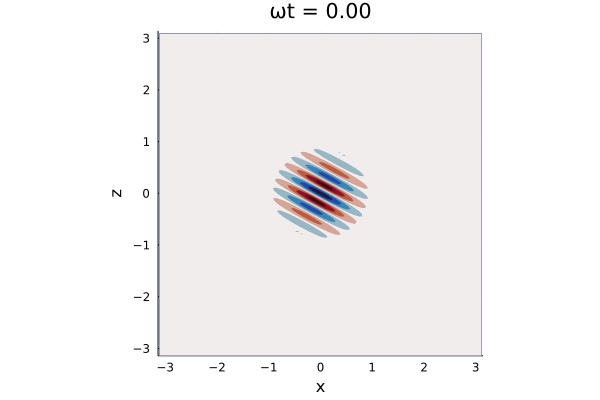

In [42]:
gif(anim,"internalwaves3.gif",fps=10)